## Model Based RL using GPs for a linear system using a RBF policy

This particular notebook contains 2 main algorithms, as discussed below. These use a simple linear system defined as 

$$s_{t+1} = 10a_t + s_t $$. 

Note that all graphs, unless stated otherwise, are of the state evolution of the real system.


Furthermore, the initial state was set at 0, with the goal set at 100. The agent was said to be close enough to the goal when it is within 10 units of it. As such, the cost function was defined as being the absolute difference between the current state and the goal. 

The key point here is that a RBF policy with 3 nodes will be used.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pylab
import time

plt.rc('font',family='Times New Roman')

import GPy
import GPyOpt

from math import *

In [8]:
%matplotlib inline

In [9]:
def f(action, current_state):
    current_state = 10*((action)) + current_state
    
    return current_state

In [32]:
#non-linear policy
def action_from_policy(policyParameters, current_state):
    num_para = 3
    action = 0
    [r,c] = policyParameters.shape
    n = c / num_para
    
    for node in range(n):
        action = pi*policyParameters[0,node*num_para]*np.exp(-1*((current_state[0,0]-policyParameters[0,1+node*num_para])*(current_state[0,0]-policyParameters[0,1+node*num_para]))/((policyParameters[0,2+node*num_para])*(policyParameters[0,2+node*num_para])))     
    
    return action            

(array([  170.,   342.,   522.,   826.,  4391.,  1946.,   796.,   513.,
          316.,   179.]),
 array([-3.11919084, -2.49383918, -1.86848753, -1.24313588, -0.61778422,
         0.00756743,  0.63291908,  1.25827074,  1.88362239,  2.50897404,
         3.1343257 ]),
 <a list of 10 Patch objects>)

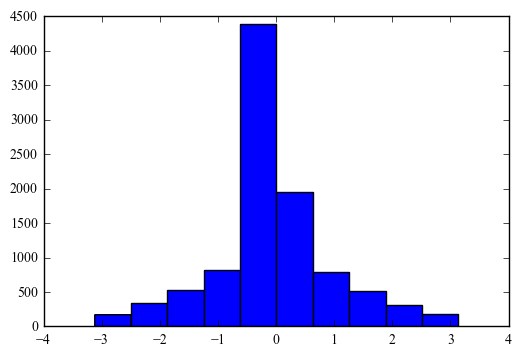

In [96]:

number_to_plot = np.array([[0]])

for i in range(10000):

    current_state = np.array([[31]])

    policyBounds = np.array([1,75,100,1,75,100,1,100,100])
    policyParameters =  np.random.uniform(low = -policyBounds, high = policyBounds)
    policyParameters = np.reshape(policyParameters,([1,9]))

    action = action_from_policy(policyParameters, current_state)
    action = np.array([[action]])
    number_to_plot = np.append(number_to_plot, action, axis=0)
plt.hist(number_to_plot)


In [158]:
def objective_function(policyParameters):
    
    global goal
    global m
    global total_count
    global to_print
    total_reward = 0
    goal_counter = 0
    counter = 0
    
    current_state = np.array([[0]])
    state_evolution = current_state
    error_evolution = current_state
    
    action = action_from_policy(policyParameters, current_state)
    
    model_input = np.array([action, current_state])
    model_input = np.reshape(model_input, ([1,2]))
    
    while goal_counter < 50 and counter < 400:
        
        current_state = m.predict(model_input)[0]
        
        current_state = np.reshape(current_state, ([1,1]))
        state_evolution = np.append(state_evolution, current_state, axis = 0)
        
        buffer_reward = abs(goal - current_state[0,0])
        
        total_reward = total_reward + buffer_reward
        
        if buffer_reward < 10:
            goal_counter += 1
            
        action = action_from_policy(policyParameters, current_state)
        model_input = np.array([action, current_state])
        model_input = np.reshape(model_input, ([1,2]))
        
        counter += 1
        
    total_count += 1
    
    if to_print == True:
        print goal_counter, counter, total_count, buffer_reward
    if buffer_reward < 5:
        plt.plot(state_evolution)
        
    return total_reward

# NOT TRUE RL

I am using this segment to see how the algorithm would behave if it only consisted of a single iteration of the RL loop. That is, the first step of learning the model is carried out sufficiently until the world model is as accurate as it can reasonably get. Following this, a single loop of optimisation iterations are carried out to find the optimal policy as given by a limited number of iterations. This is done to see if, under the best circumstances, a sufficiently accurate policy can be obtained. 

Such an endeavour would not be possible in a high dimensional problem due to the fact that making a accurate world model with such little data is not feasible. 

In [175]:
total_it = 500
current_state = np.random.uniform(-pi,pi,1)
state_evolution = np.zeros((total_it,1))#, dtype='int64')
# input_states = np.zeros((total_it,2))#, dtype='int64')
# output_states = np.zeros((total_it,1))#, dtype='int64')
prediction_evolution = np.zeros((total_it,1))#, dtype='int64')
k = GPy.kern.RBF(input_dim=2, variance=1., lengthscale=1.)

for i in range(total_it):

    if i%50 == 0:
        print i
    action = np.random.uniform(-pi, pi, 1)

    # state_evolution[i] = current_state
    bufferInput = np.array([action,current_state])
    bufferInput = np.reshape(bufferInput, ([1, 2]))

    if i > 0:
        input_states = np.append(input_states, bufferInput, axis = 0)
    else:
        input_states = bufferInput

    current_state = f(action, current_state)
    bufferState = np.reshape(current_state, ([1,1]))
    if i > 0:
        output_states = np.append(output_states, bufferState, axis=0)
    else:
        output_states = bufferState

    if i > 0:
        # time.sleep(0.2)
        prediction = m1.predict(bufferInput)[0]
        # print prediction
        prediction_evolution[i,0] = prediction

    m1 = GPy.models.GPRegression(input_states, output_states, k)
    m1.optimize()

    action = np.random.uniform(-pi, pi, 1)
print total_it

0
50
100
150
200
250
300
350
400
450
500


The plot below shows the state evolution of the real system and the predictions made by the world model, at each time step. As can be seen by the red plot, the absolute square error drop rapdily after about 20 steps. This is of course to be expected due to the simplicity of the linear system. 

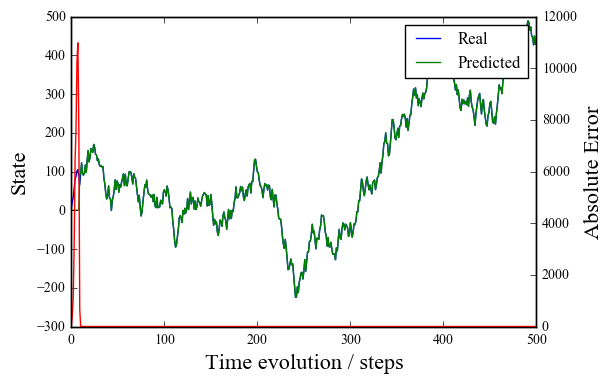

In [176]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(output_states[00:])
ax1.plot(prediction_evolution[00:])
ax2.plot(((np.abs(prediction_evolution[00:]-output_states[00:]))*(np.abs(prediction_evolution[00:]-output_states[00:]))),  'r')

ax1.legend(['Real', 'Predicted'], loc='upper right')
ax1.set_xlabel('Time evolution / steps', fontsize=16)
ax1.set_ylabel('State', fontsize=16)
ax2.set_ylabel('Absolute Error', fontsize=16)
#pylab.savefig('./stateEvolution.eps', format='eps')
plt.show()

In [177]:
bounds = [{'domain': (-1,1), 'name': 'var_1', 'type': 'continuous', 'dimensionality':1},
         {'domain': (-50,50), 'name': 'var_2', 'type': 'continuous', 'dimensionality':1},
          {'domain': (0,100), 'name': 'var_3', 'type': 'continuous', 'dimensionality':1},
          {'domain': (-1,1), 'name': 'var_4', 'type': 'continuous', 'dimensionality':1},
         {'domain': (-50,50), 'name': 'var_5', 'type': 'continuous', 'dimensionality':1},
          {'domain': (0,100), 'name': 'var_6', 'type': 'continuous', 'dimensionality':1},
          {'domain': (-1,1), 'name': 'var_7', 'type': 'continuous', 'dimensionality':1},
         {'domain': (-50,50), 'name': 'var_8', 'type': 'continuous', 'dimensionality':1},
          {'domain': (0,100), 'name': 'var_9', 'type': 'continuous', 'dimensionality':1}]
          

The optimisation loop is carried out below; the graph shows some selected state evolutions for when the final point was within the alloted range for being accurate.

0 400 1 256.484008789
0 400 2 235.947441101
0 400 3 331.717617035
50 80 4 0.71150970459
0 400 5 199.884727478
0 400 6 176.263553619
0 400 7 207.917743683
0 400 8 158.097805023
0 400 9 157.905475616
0 400 10 158.776245117
0 400 11 145.010848999
50 80 12 1.96168518066
50 80 13 1.96168518066


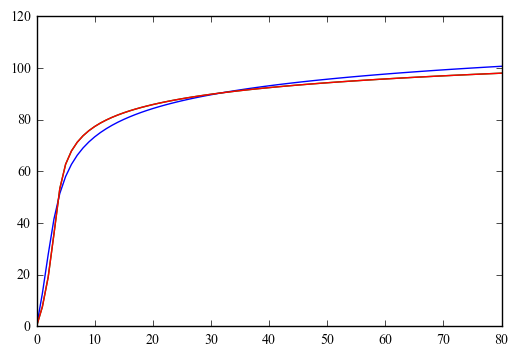

In [178]:
m = m1

total_count = 0
goal = 100
to_print = True
myBopt = GPyOpt.methods.BayesianOptimization(f = objective_function, domain = bounds, acquisition_type ='MPI', num_cores=2, verbosity=True)
max_iter = 200              # evaluation budget
myBopt.run_optimization(max_iter) 

In [179]:
policyParameters = myBopt.X[np.argmin(myBopt.Y)]
policyParameters = np.reshape(policyParameters, ([1,9]))
print policyParameters, np.argmin(myBopt.Y)

[[  0.45007649 -46.10266319  91.26599797   0.56319172  32.1481346
   25.60059894   0.48299139  16.09636851  38.68974655]] 3


In [182]:
def run_simulation(policyParameters, iterations, append):
    
    global input_states
    global output_states
    
    currentState = np.array([[0]])
    bufferCurrentState = currentState
    if append == True:
        output_states = np.append(output_states, bufferCurrentState, axis = 0)
    
    action = action_from_policy(policyParameters, currentState)

    bufferInput_policy = np.array([action,bufferCurrentState])
    bufferInput_policy = np.reshape(bufferInput_policy, ([1, 2]))
    
    if append == True:
        input_states = np.append(input_states, bufferInput_policy, axis = 0)
        
    for i in range(iterations):
        bufferCurrentState = f(action, bufferCurrentState)
        #bufferCurrentState = m.predict(bufferInput_policy)[0]
        bufferCurrentState = np.reshape(bufferCurrentState, ([1,1]))
        if append == True:
            output_states = np.append(output_states, bufferCurrentState, axis = 0)
        
        currentState = np.append(currentState,bufferCurrentState, axis = 0)

        action = action_from_policy(policyParameters, bufferCurrentState)
        bufferInput_policy = np.array([action,bufferCurrentState])
        bufferInput_policy = np.reshape(bufferInput_policy, ([1, 2]))
        if append == True:
            input_states = np.append(input_states, bufferInput_policy, axis = 0)
         
    plt.figure()
    plt.plot(currentState)

    return input_states, output_states

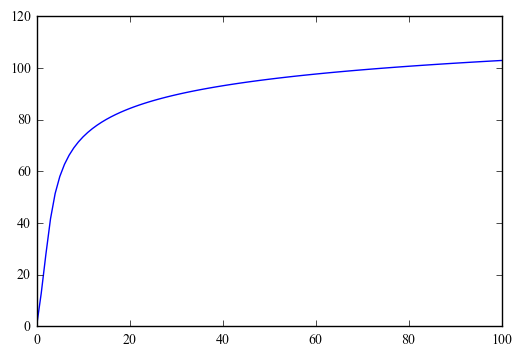

In [183]:
input_states, output_states = run_simulation(policyParameters, iterations = 100, append = False)

In [76]:
#objective_function(policyParameters)

# TRUE RL 
 

In [138]:
total_it = 50
current_state = np.random.uniform(-pi,pi,1)
state_evolution = np.zeros((total_it,1))#, dtype='int64')
# input_states = np.zeros((total_it,2))#, dtype='int64')
# output_states = np.zeros((total_it,1))#, dtype='int64')
prediction_evolution = np.zeros((total_it,1))#, dtype='int64')
k = GPy.kern.RBF(input_dim=2, variance=1., lengthscale=1.)

for i in range(total_it):

    if i%25 == 0:
        print i
    action = np.random.uniform(-pi, pi, 1)

    # state_evolution[i] = current_state
    bufferInput = np.array([action,current_state])
    bufferInput = np.reshape(bufferInput, ([1, 2]))

    if i > 0:
        input_states = np.append(input_states, bufferInput, axis = 0)
    else:
        input_states = bufferInput

    current_state = f(action, current_state)
    bufferState = np.reshape(current_state, ([1,1]))
    if i > 0:
        output_states = np.append(output_states, bufferState, axis=0)
    else:
        output_states = bufferState

    if i > 0:
        # time.sleep(0.2)
        prediction = m2.predict(bufferInput)[0]
        # print prediction
        prediction_evolution[i,0] = prediction

    m2 = GPy.models.GPRegression(input_states, output_states, k)
    m2.optimize()

    action = np.random.uniform(-pi, pi, 1)
print total_it

0
25
50


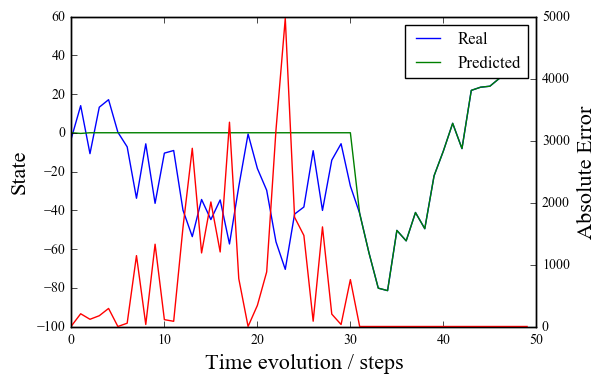

In [139]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(output_states[00:])
ax1.plot(prediction_evolution[00:])
ax2.plot(((np.abs(prediction_evolution[00:]-output_states[00:]))*(np.abs(prediction_evolution[00:]-output_states[00:]))),  'r')

ax1.legend(['Real', 'Predicted'], loc='upper right')
ax1.set_xlabel('Time evolution / steps', fontsize=16)
ax1.set_ylabel('State', fontsize=16)
ax2.set_ylabel('Absolute Error', fontsize=16)
#pylab.savefig('./stateEvolution.eps', format='eps')
plt.show()

In [140]:
bounds = [{'domain': (-1,1), 'name': 'var_1', 'type': 'continuous', 'dimensionality':1},
         {'domain': (-50,50), 'name': 'var_2', 'type': 'continuous', 'dimensionality':1},
          {'domain': (0,100), 'name': 'var_3', 'type': 'continuous', 'dimensionality':1},
          {'domain': (-1,1), 'name': 'var_4', 'type': 'continuous', 'dimensionality':1},
         {'domain': (-50,50), 'name': 'var_5', 'type': 'continuous', 'dimensionality':1},
          {'domain': (0,100), 'name': 'var_6', 'type': 'continuous', 'dimensionality':1},
          {'domain': (-1,1), 'name': 'var_7', 'type': 'continuous', 'dimensionality':1},
         {'domain': (-50,50), 'name': 'var_8', 'type': 'continuous', 'dimensionality':1},
          {'domain': (0,100), 'name': 'var_9', 'type': 'continuous', 'dimensionality':1}]
          

[[ -0.80787697  19.86911991  41.88121499  -0.56451803   2.46333503
    3.27243895   0.85628621  42.32117144   2.27407563]] 0
(101, 2) (101, 1)
[[  0.65896555  46.02807233  74.32340789   0.63068777  -2.28830558
   17.16035294   0.81468797  24.17966873  37.74104201]] 9
(152, 2) (152, 1)
[[  0.37368723 -46.67202641  89.05107441   0.2111869    8.61231449
   95.17461902   0.57914018   5.70433435  40.05058337]] 3
(203, 2) (203, 1)
[[ -0.45588119  45.18928021  90.14217819   0.94112023 -38.49893251
   36.38078186   0.65448386  31.67649379  26.70830961]] 20
(254, 2) (254, 1)
[[  0.15103804 -29.78529609  53.24672893  -0.51741124   2.53792342
   43.98543961   0.27636406  23.38352797  25.3721047 ]] 19
(305, 2) (305, 1)
[[  0.36214551 -28.61183209  46.19353484   0.92012212  38.46643555
    8.1553144    0.22530474  -9.84708869  90.22013817]] 10
(356, 2) (356, 1)
[[ -8.23968850e-02  -3.82788953e+01   5.08258998e+01  -6.65792556e-01
   -4.34169204e+00   1.43679317e+01   5.84637123e-01  -4.04643794e+01

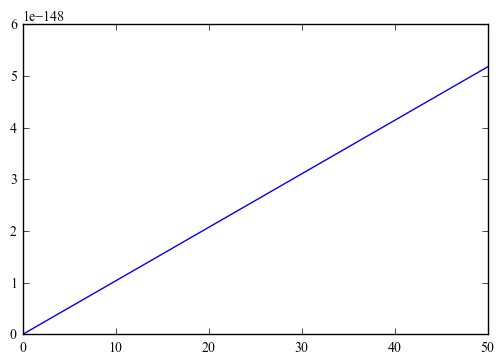

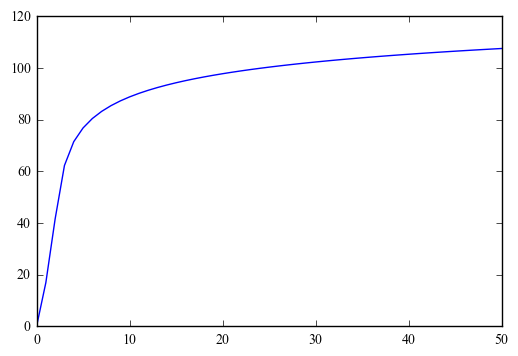

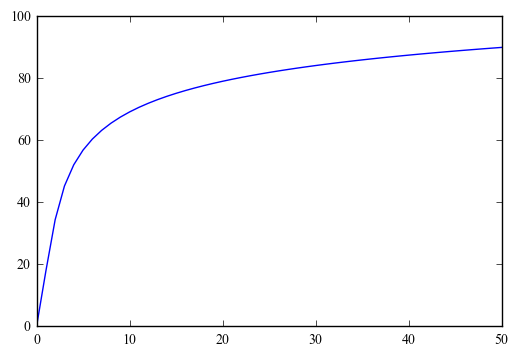

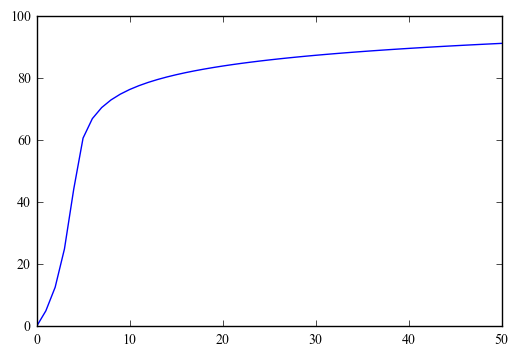

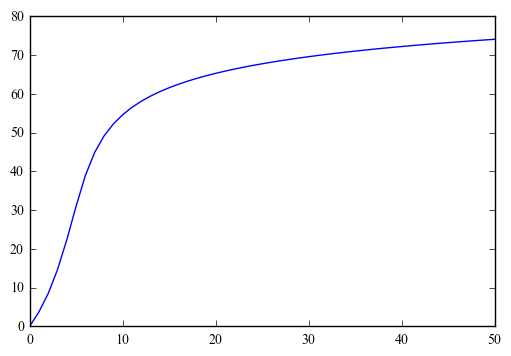

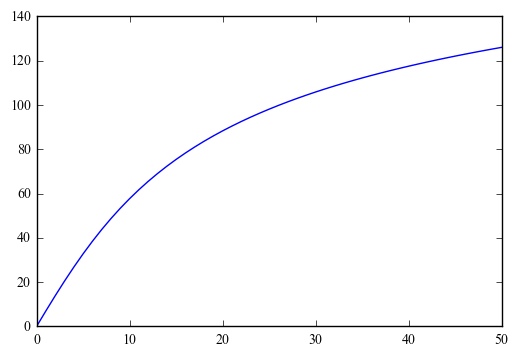

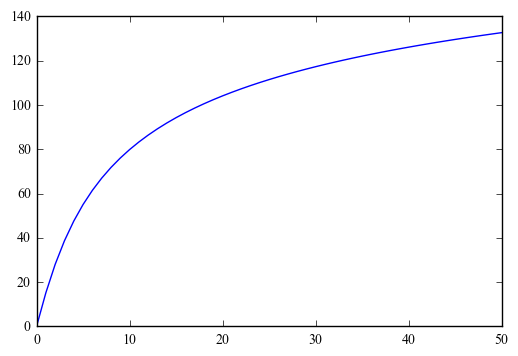

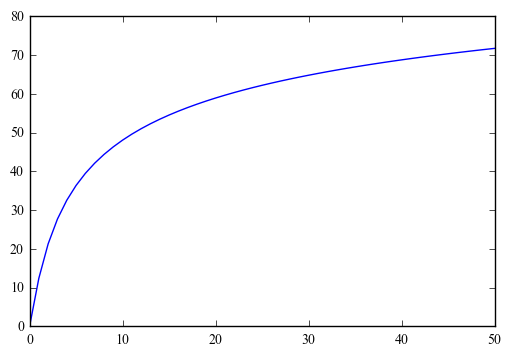

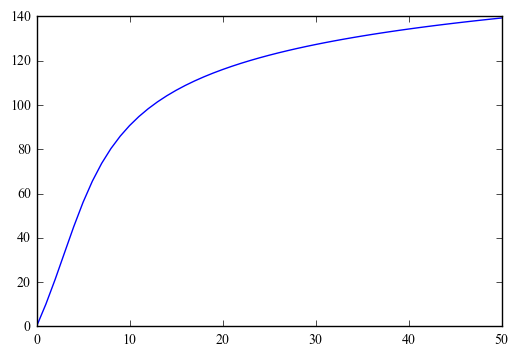

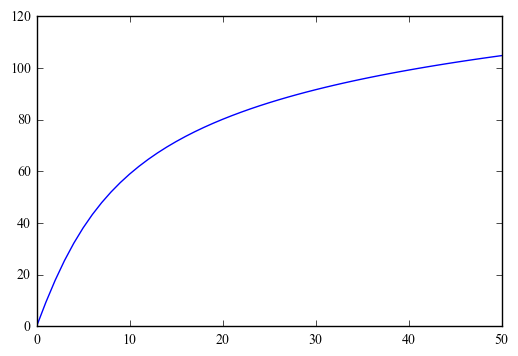

In [144]:
to_print = False
m = m2
for i in range(10):
    
    total_count = 0
    goal = 100
    myBopt = GPyOpt.methods.BayesianOptimization(f = objective_function, domain = bounds, acquisition_type ='MPI', num_cores=4, verbosity=True)
    max_iter = 100             # evaluation budget
    myBopt.run_optimization(max_iter)
    
    policyParameters = myBopt.X[np.argmin(myBopt.Y)]
    policyParameters = np.reshape(policyParameters, ([1,9]))
    print policyParameters, np.argmin(myBopt.Y)
    
    input_states, output_states = run_simulation(policyParameters, append = True)
    print input_states.shape, output_states.shape
    m = GPy.models.GPRegression(input_states, output_states, k)
    m.optimize()
    

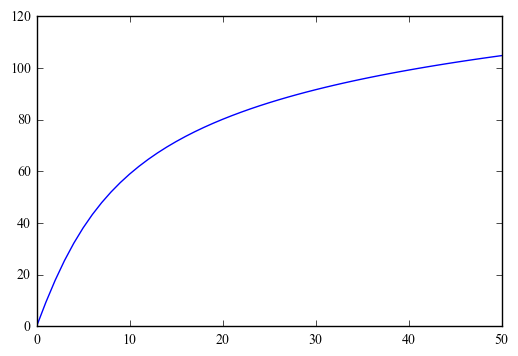

In [145]:
input_states, output_states = run_simulation(policyParameters, append=False)

In [16]:
np.exp(1)

2.7182818284590451